# Load hive data

In [27]:
import pandas as pd

root_dir = "abfss://beehivestorage@beehiveprojectlake.dfs.core.windows.net/"
source = root_dir+'silver/processing/'

try:
    flow = pd.read_csv(source+'flow_schwartau.csv', parse_dates=['timestamp'])
except FileNotFoundError:
    try:
        flow = pd.read_csv(source+'flow_wurzburg.csv', parse_dates=['timestamp'])
    except FileNotFoundError:
        # dummy DataFrame if no file found
        flow = pd.DataFrame(columns=["timestamp", "flow"], dtype=int)
        flow["timestamp"] = pd.to_datetime(flow["timestamp"])
try:
    humidity = pd.read_csv(source+'humidity_schwartau.csv', parse_dates=['timestamp'])
except FileNotFoundError:
    try:
        humidity = pd.read_csv(source+'humidity_wurzburg.csv', parse_dates=['timestamp'])
    except FileNotFoundError:
        # dummy DataFrame if no file found
        humidity = pd.DataFrame(columns=["timestamp", "humidity"], dtype=int)
        humidity["timestamp"] = pd.to_datetime(humidity["timestamp"])
try:
    temperature = pd.read_csv(source+'temperature_schwartau.csv', parse_dates=['timestamp'])
except FileNotFoundError:
    try:
        temperature = pd.read_csv(source+'temperature_wurzburg.csv', parse_dates=['timestamp'])
    except FileNotFoundError:
        # dummy DataFrame if no file found
        temperature = pd.DataFrame(columns=["timestamp", "temperature"], dtype=int)
        temperature["timestamp"] = pd.to_datetime(temperature["timestamp"])
try:
    weight = pd.read_csv(source+'weight_schwartau.csv', parse_dates=['timestamp'])
except FileNotFoundError:
    try:
        weight = pd.read_csv(source+'weight_wurzburg.csv', parse_dates=['timestamp'])
    except FileNotFoundError:
        # dummy DataFrame if no file found
        weight = pd.DataFrame(columns=["timestamp", "weight"], dtype=int)
        weight["timestamp"] = pd.to_datetime(weight["timestamp"])


StatementMeta(CLSYNB, 31, 28, Finished, Available, Finished)

In [28]:
flow.info(show_counts=True)

StatementMeta(CLSYNB, 31, 29, Finished, Available, Finished)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2513836 entries, 0 to 2513835
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   timestamp  2513836 non-null  datetime64[ns]
 1   flow       2513836 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 38.4 MB


In [29]:
humidity.info() # some missing values for humidity

StatementMeta(CLSYNB, 31, 30, Finished, Available, Finished)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  1761 non-null   datetime64[ns]
 1   humidity   1749 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 27.6 KB


In [30]:
temperature.info() # some missing temp values

StatementMeta(CLSYNB, 31, 31, Finished, Available, Finished)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253430 entries, 0 to 253429
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   timestamp    253430 non-null  datetime64[ns]
 1   temperature  251398 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.9 MB


In [31]:
weight.info() # some missing weight values

StatementMeta(CLSYNB, 31, 32, Finished, Available, Finished)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  1761 non-null   datetime64[ns]
 1   weight     1749 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 27.6 KB


# Explore hive data

## Flow

In [32]:
flow.head(15) # arranged by timestamp, every 1 minute
(flow['timestamp'] - flow['timestamp'].shift(1)).value_counts() # is it really arranged so regularly? no

StatementMeta(CLSYNB, 31, 33, Finished, Available, Finished)

0 days 00:01:00        2513704
0 days 00:02:00            112
0 days 01:01:00              6
-1 days +23:01:00            4
5 days 09:32:00              2
0 days 11:56:00              2
0 days 02:44:00              2
1 days 01:19:00              2
-880 days +00:00:00          1
Name: timestamp, dtype: int64

In [33]:
# sort by timestamp because of that big negative step
flow.sort_values(by='timestamp').head(20) # timestamps always come in pairs of one small index, one large index

StatementMeta(CLSYNB, 31, 34, Finished, Available, Finished)

,timestamp,flow
0,2017-01-01 14:15:00,0
1256918,2017-01-01 14:15:00,0
1256919,2017-01-01 14:16:00,0
1,2017-01-01 14:16:00,0
2,2017-01-01 14:17:00,0
1256920,2017-01-01 14:17:00,0
3,2017-01-01 14:18:00,0
1256921,2017-01-01 14:18:00,0
4,2017-01-01 14:19:00,0
1256922,2017-01-01 14:19:00,0


In [34]:
# suppose the document is written in two steps:
# all counts in one direction, arranged by timestamp; then repeat in the other direction
flow.loc[:flow.shape[0]//2-1, 'flow'].agg(['min', 'max']) # all non-positive values
flow.loc[flow.shape[0]//2:, 'flow'].agg(['min', 'max']) # all non-negative values

StatementMeta(CLSYNB, 31, 35, Finished, Available, Finished)

min       0
max    7999
Name: flow, dtype: int64

In [35]:
# divide flow into the two types of counts, in and out
departures = flow.iloc[:flow.shape[0]//2-1].copy()
arrivals = flow.iloc[flow.shape[0]//2:].copy()

StatementMeta(CLSYNB, 31, 36, Finished, Available, Finished)

In [36]:
departures.duplicated().sum() # are all timestamps unique? no
departures.loc[departures.duplicated(), 'timestamp'].dt.date.value_counts() # when are times duplicated?
departures.loc[departures.duplicated(), 'timestamp'].dt.day_name().unique() # this is always on a Sunday
departures.loc[departures.duplicated(), 'timestamp'].dt.hour.unique() # very early in the morning

# fulfills all expectations of time change

StatementMeta(CLSYNB, 31, 37, Finished, Available, Finished)

array([2])

In [37]:
# because local time changes with season, convert to UTC
departures['timestamp'] = departures['timestamp'].dt.tz_localize('Europe/Berlin', ambiguous='infer').dt.tz_convert("UTC")

# drop duplicates just in case
departures = departures.drop_duplicates().copy() 

StatementMeta(CLSYNB, 31, 38, Finished, Available, Finished)

In [38]:
arrivals['timestamp'] = arrivals['timestamp'].dt.tz_localize('Europe/Berlin', ambiguous='infer').dt.tz_convert("UTC")

arrivals = arrivals.drop_duplicates().copy() # drop duplicates just in case

StatementMeta(CLSYNB, 31, 39, Finished, Available, Finished)

StatementMeta(CLSYNB, 31, 40, Finished, Available, Finished)

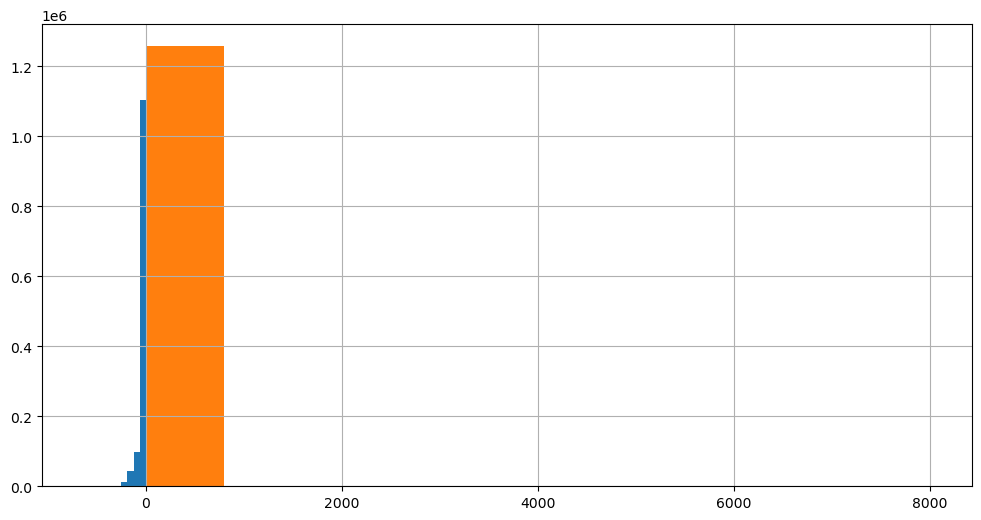

In [39]:
# what's the distribution of counts?
departures['flow'].hist(figsize=(12,6));
arrivals['flow'].hist(figsize=(12,6)); # some numbers seem like outliers

In [40]:
arrivals.nlargest(20, 'flow') # 7999 is a pretty big gap from the rest of the figures

StatementMeta(CLSYNB, 31, 41, Finished, Available, Finished)

,timestamp,flow
2084055,2018-08-04 23:25:00+00:00,7999
2098359,2018-08-14 21:50:00+00:00,7999
2107004,2018-08-20 21:56:00+00:00,7999
2107005,2018-08-20 21:57:00+00:00,7999
2107009,2018-08-20 22:01:00+00:00,7999
2107010,2018-08-20 22:02:00+00:00,7999
2107023,2018-08-20 22:15:00+00:00,3148
2101589,2018-08-17 03:41:00+00:00,3042
1531827,2017-07-16 20:39:00+00:00,2755
2091430,2018-08-10 02:21:00+00:00,2629


StatementMeta(CLSYNB, 31, 42, Finished, Available, Finished)

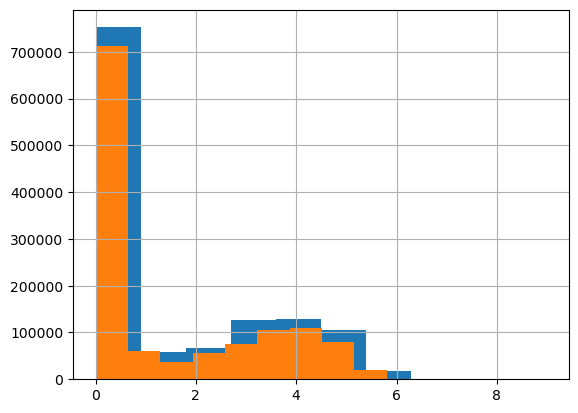

In [41]:
import numpy as np
# take logarithm to deal with long tail and inspect distribution
np.log1p(arrivals["flow"]).hist(); # seems bimodal
np.log1p(departures["flow"].abs()).hist(); # seems bimodal

StatementMeta(CLSYNB, 31, 43, Finished, Available, Finished)

<Axes: xlabel='timestamp'>

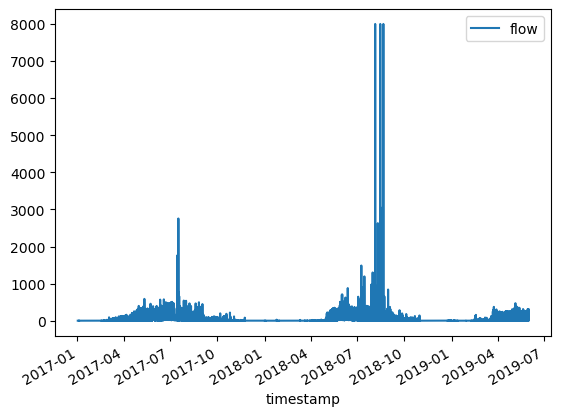

In [42]:
arrivals.plot(kind='line', x='timestamp', y='flow') # all the highest values cluster in a few days. measurement error?

Let's take flow data as bimodal. We'll identify the two mean values, and exclude data points beyond $3\sigma$ from those means.

In [43]:
flow.empty

StatementMeta(CLSYNB, 31, 44, Finished, Available, Finished)

False

In [44]:
from sklearn.mixture import GaussianMixture

def remove_flow_outliers(df):
    log_transform = np.log1p(df["flow"].abs()) # log transform to rein in long tails
    gmm = GaussianMixture(n_components=2, random_state=123) # GaussianMixture to handle bimodal distributions
    gmm.fit(log_transform.to_frame())
    means = gmm.means_.flatten()
    stds = (gmm.covariances_**0.5).flatten()
    
    # identify 3sigma cutoff for outliers
    mode1cutoff = means[0]+3*stds[0]
    mode2cutoff = means[1]+3*stds[1]
    
    # select indexes of rows greater than 3sigma cutoff
    cutoff_indexes = log_transform.loc[log_transform > max(mode1cutoff,mode2cutoff)].index
    
    # drop cutoff indexes
    return df.drop(cutoff_indexes)

if not flow.empty:
    arrivals = remove_flow_outliers(arrivals)
    departures = remove_flow_outliers(departures)

StatementMeta(CLSYNB, 31, 45, Finished, Available, Finished)

## Humidity

In [45]:
humidity['humidity'].describe() # humidity should not be negative

StatementMeta(CLSYNB, 31, 46, Finished, Available, Finished)

count    1749.000000
mean       83.987816
std        26.501959
min      -100.000000
25%        79.330000
50%        91.070000
75%        96.610000
max       100.000000
Name: humidity, dtype: float64

StatementMeta(CLSYNB, 31, 47, Finished, Available, Finished)

<Axes: xlabel='timestamp'>

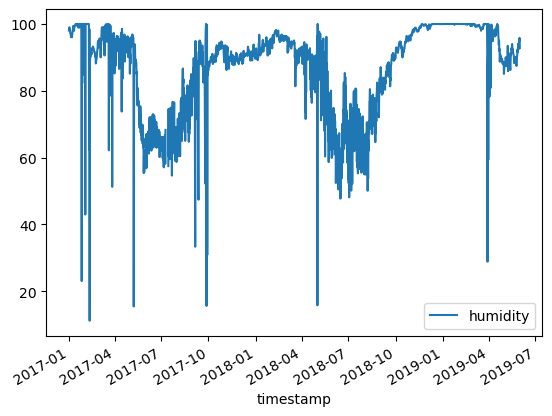

In [46]:
humidity2 = humidity.copy() # copy to see what happens when fixing values
humidity2['humidity'] = humidity2['humidity'].abs() # all positive values
humidity2.plot(kind='line', x='timestamp', y='humidity') # doesn't look unreasonable

In [47]:
humidity['humidity'] = humidity['humidity'].abs() # correct original dataframe

StatementMeta(CLSYNB, 31, 48, Finished, Available, Finished)

In [48]:
humidity.info()

StatementMeta(CLSYNB, 31, 49, Finished, Available, Finished)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  1761 non-null   datetime64[ns]
 1   humidity   1749 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 27.6 KB


In [49]:
(humidity['timestamp'] - humidity['timestamp'].shift(1)).value_counts() # looks very regular if we assume the time changes

StatementMeta(CLSYNB, 31, 50, Finished, Available, Finished)

0 days 12:00:00    1755
0 days 13:00:00       3
0 days 11:00:00       2
Name: timestamp, dtype: int64

In [50]:
# humidity['timestamp'].dt.tz_localize("Europe/Berlin", ambiguous='infer')
# cannot infer dst status

StatementMeta(CLSYNB, 31, 51, Finished, Available, Finished)

In [51]:
# investigate problem dates
humidity.loc[humidity['timestamp'].dt.strftime('%Y-%m-%d') == '2017-10-29'] # indexes 601:602
humidity.loc[humidity['timestamp'].dt.strftime('%Y-%m-%d') == '2018-10-28'] # indexes 1329:1330

# zoom out a little to get the pattern of measurements
humidity.loc[598:604]
humidity.loc[1326:1332]


# it seems all ambiguous dates (at 2am) are recorded BEFORE the clocks change

StatementMeta(CLSYNB, 31, 52, Finished, Available, Finished)

,timestamp,humidity
1326,2018-10-26 14:00:00,95.02
1327,2018-10-27 02:00:00,95.60
1328,2018-10-27 14:00:00,95.94
1329,2018-10-28 02:00:00,96.52
1330,2018-10-28 13:00:00,96.55
1331,2018-10-29 01:00:00,96.03
1332,2018-10-29 13:00:00,95.57


In [52]:
pd.Series(True, index=humidity.index) # can we make a Series of True with the same shape as the 'humidity' column?

StatementMeta(CLSYNB, 31, 53, Finished, Available, Finished)

0       True
1       True
2       True
3       True
4       True
        ... 
1756    True
1757    True
1758    True
1759    True
1760    True
Length: 1761, dtype: bool

In [53]:
# any ambiguous times ARE in daylight saving (summer time)
humidity['timestamp'] = humidity['timestamp'].dt.tz_localize("Europe/Berlin", ambiguous=pd.Series(True, index=humidity.index)).dt.tz_convert("UTC")

StatementMeta(CLSYNB, 31, 54, Finished, Available, Finished)

In [54]:
humidity.duplicated().sum()

StatementMeta(CLSYNB, 31, 55, Finished, Available, Finished)

0

In [55]:
humidity.loc[humidity['humidity'].isnull()] # look at null values for pattern

# was there some problem at the site for sereral days? storm? sickness?

StatementMeta(CLSYNB, 31, 56, Finished, Available, Finished)

,timestamp,humidity
378,2017-07-09 12:00:00+00:00,NaN
379,2017-07-10 00:00:00+00:00,NaN
380,2017-07-10 12:00:00+00:00,NaN
381,2017-07-11 00:00:00+00:00,NaN
382,2017-07-11 12:00:00+00:00,NaN
383,2017-07-12 00:00:00+00:00,NaN
384,2017-07-12 12:00:00+00:00,NaN
385,2017-07-13 00:00:00+00:00,NaN
386,2017-07-13 12:00:00+00:00,NaN
387,2017-07-14 00:00:00+00:00,NaN


## Temperature

In [56]:
# convert to UTC
temperature['timestamp'] = temperature['timestamp'].dt.tz_localize("Europe/Berlin", ambiguous="infer").dt.tz_convert("UTC")

StatementMeta(CLSYNB, 31, 57, Finished, Available, Finished)

In [57]:
temperature["temperature"].describe() # these temps seem high at first glance, but normal if measured inside the beehive

StatementMeta(CLSYNB, 31, 58, Finished, Available, Finished)

count    251398.000000
mean         22.609671
std          11.702222
min          -7.260000
25%          12.450000
50%          24.480000
75%          34.220000
max          37.530000
Name: temperature, dtype: float64

In [58]:
# where is data missing? several whole days clustered together (one whole day by itself), and scattered at other times
temperature.loc[temperature['temperature'].isna(), 'timestamp'].dt.date.value_counts()

StatementMeta(CLSYNB, 31, 59, Finished, Available, Finished)

2017-07-10    288
2017-07-12    288
2017-07-11    288
2017-07-13    288
2019-03-09    288
2017-07-09    249
2017-07-14    153
2018-04-28    142
2018-05-16     32
2019-03-08     15
2017-01-01      1
Name: timestamp, dtype: int64

In [59]:
temperature.duplicated().sum()

StatementMeta(CLSYNB, 31, 60, Finished, Available, Finished)

0

## Weight

In [60]:
# same logic applies as with humidity
weight['timestamp'] = weight['timestamp'].dt.tz_localize("Europe/Berlin", ambiguous=pd.Series(True, index=weight.index)).dt.tz_convert("UTC")

StatementMeta(CLSYNB, 31, 61, Finished, Available, Finished)

In [61]:
weight.duplicated().sum()

StatementMeta(CLSYNB, 31, 62, Finished, Available, Finished)

0

In [62]:
weight['weight'].describe() # I'd guess measurements are in grams

# cannot have negative weight

StatementMeta(CLSYNB, 31, 63, Finished, Available, Finished)

count     1749.000000
mean     56807.637313
std      16926.937629
min       -172.440000
25%      49793.360000
50%      58029.270000
75%      67322.570000
max      92042.230000
Name: weight, dtype: float64

In [63]:
weight.loc[weight['weight'] < 0] # investigate negative weights

StatementMeta(CLSYNB, 31, 64, Finished, Available, Finished)

,timestamp,weight
964,2018-04-28 12:00:00+00:00,-170.61
965,2018-04-29 00:00:00+00:00,-172.44
966,2018-04-29 12:00:00+00:00,-167.10
1001,2018-05-17 00:00:00+00:00,-101.54
1061,2018-06-16 00:00:00+00:00,-157.49
1062,2018-06-16 12:00:00+00:00,-143.38
1063,2018-06-17 00:00:00+00:00,-157.63
1064,2018-06-17 12:00:00+00:00,-149.62
1065,2018-06-18 00:00:00+00:00,-162.12
1066,2018-06-18 12:00:00+00:00,-147.43


StatementMeta(CLSYNB, 31, 65, Finished, Available, Finished)

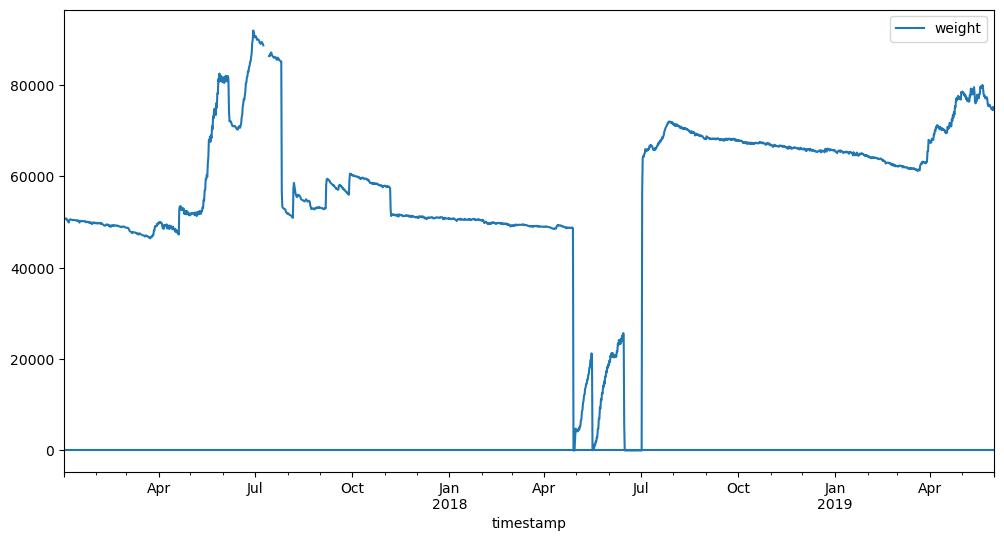

In [64]:
# plot them to look for pattern
from matplotlib import pyplot as plt

weight.plot(kind='line', x='timestamp', y='weight', figsize=(12, 6))
plt.axhline(0)

# they're really not even visible

StatementMeta(CLSYNB, 31, 66, Finished, Available, Finished)

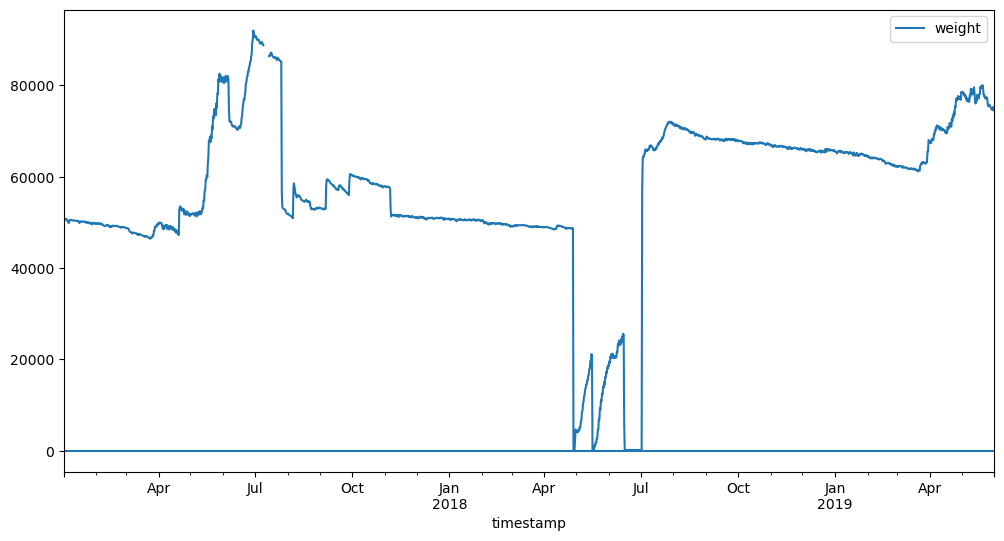

In [65]:
# test out making negatives positive
weight2 = weight.copy()
weight2['weight'] = weight2['weight'].abs()
weight2.plot(kind='line', x='timestamp', y='weight', figsize=(12, 6))
plt.axhline(0) # looks reasonable

In [66]:
weight['weight'] = weight['weight'].abs()

StatementMeta(CLSYNB, 31, 67, Finished, Available, Finished)

## Reassembly and regularity

### Flow

In [67]:
# merge flow figures back into one dataframe
flow = departures.merge(arrivals, on='timestamp', how='outer', suffixes=['_out', '_in'])
flow = flow.sort_values(by='timestamp')

StatementMeta(CLSYNB, 31, 68, Finished, Available, Finished)

In [68]:
# timestamps still aren't perfectly regular
(flow['timestamp'] - flow['timestamp'].shift(1)).value_counts()

StatementMeta(CLSYNB, 31, 69, Finished, Available, Finished)

0 days 00:01:00    1256857
0 days 00:02:00         56
5 days 09:32:00          1
0 days 11:56:00          1
0 days 02:44:00          1
1 days 01:19:00          1
Name: timestamp, dtype: int64

In [69]:
# create a regular, one-minute interval
if not flow.empty:
    flow = flow.set_index("timestamp").resample("min").asfreq()#.reset_index()

StatementMeta(CLSYNB, 31, 70, Finished, Available, Finished)

### Humidity

In [70]:
# timestamps are regular at 12 hours
(humidity['timestamp'] - humidity['timestamp'].shift(1)).value_counts()

StatementMeta(CLSYNB, 31, 71, Finished, Available, Finished)

0 days 12:00:00    1760
Name: timestamp, dtype: int64

### Temperature

In [71]:
# timestamps are regular at five minutes
(temperature['timestamp'] - temperature['timestamp'].shift(1)).value_counts()

StatementMeta(CLSYNB, 31, 72, Finished, Available, Finished)

0 days 00:05:00    253429
Name: timestamp, dtype: int64

### Weight

In [72]:
# timestamps are regular at 12 hours
(weight['timestamp'] - weight['timestamp'].shift(1)).value_counts()

StatementMeta(CLSYNB, 31, 73, Finished, Available, Finished)

0 days 12:00:00    1760
Name: timestamp, dtype: int64

# Hive data cleaning

## Define cleaning functions

In [73]:
def clean_splits(df):
    # convert to UTC
    df['timestamp'] = df['timestamp'].dt.tz_localize('Europe/Berlin', ambiguous='infer').dt.tz_convert("UTC")
    
    # drop duplicates just in case
    df = df.drop_duplicates().copy() 

    # remove outliers
    df = remove_flow_outliers(df)

    return df

def clean_flow(flow):
    # divide flow into the two types of counts, in and out
    departures = flow.loc[:flow.shape[0]/2-1].copy()
    arrivals = flow.loc[flow.shape[0]/2:].copy()

    # clean up individual flow directions
    departures = clean_splits(departures)
    arrivals = clean_splits(arrivals)

    # recombine split files
    flow = departures.merge(arrivals, on='timestamp', how='outer', suffixes=['_out', '_in'])
    flow = flow.sort_values(by='timestamp')

    # create a regular, one-minute interval
    flow = flow.set_index("timestamp").resample("min").asfreq().reset_index()

    return flow

StatementMeta(CLSYNB, 31, 74, Finished, Available, Finished)

In [74]:
def clean_humidity(humidity):
    # humidity values cannot be negative
    humidity['humidity'] = humidity['humidity'].abs()

    # convert to UTC
    # any ambiguous times ARE in daylight saving (summer time)
    humidity['timestamp'] = humidity['timestamp'].dt.tz_localize("Europe/Berlin", ambiguous=pd.Series(True, index=humidity.index)).dt.tz_convert("UTC")

    # drop duplicates just in case
    humidity = humidity.drop_duplicates().copy() 

    # create a regular, 12-hour interval
    humidity = humidity.set_index("timestamp").resample("12h").asfreq().reset_index()

    return humidity

StatementMeta(CLSYNB, 31, 75, Finished, Available, Finished)

In [75]:
def clean_temperature(temperature):
    # convert to UTC
    temperature['timestamp'] = temperature['timestamp'].dt.tz_localize("Europe/Berlin", ambiguous="infer").dt.tz_convert("UTC")

    # drop duplicates just in case
    temperature = temperature.drop_duplicates().copy() 

    # create a regular, five-minute interval
    temperature = temperature.set_index("timestamp").resample("5min").asfreq().reset_index()

    return temperature

StatementMeta(CLSYNB, 31, 76, Finished, Available, Finished)

In [76]:
def clean_weight(weight):
    # weight values cannot be negative
    weight['weight'] = weight['weight'].abs()

    # convert to UTC
    # any ambiguous times ARE in daylight saving (summer time)
    weight['timestamp'] = weight['timestamp'].dt.tz_localize("Europe/Berlin", ambiguous=pd.Series(True, index=weight.index)).dt.tz_convert("UTC")

    # drop duplicates just in case
    weight = weight.drop_duplicates().copy() 

    # create a regular, 12-hour interval
    weight = weight.set_index("timestamp").resample("12h").asfreq().reset_index()

    return weight

StatementMeta(CLSYNB, 31, 77, Finished, Available, Finished)

## Clean and write all files

In [77]:
import fsspec

# folder for cleaned hive files
hive_sink = root_dir+'silver/'

# store all DataFrames for weather-data gathering
all_dfs = {
    "schwartau": [],
    "wurzburg": []
}

# list files in source
fs = fsspec.filesystem("abfs")
file_list_longform = fs.ls(source)
file_list = [file.rsplit("/", maxsplit=1)[1] for file in file_list_longform]

for file in file_list:
    print(file)
    # skip "hidden" files
    if file.startswith("."):
        continue
    
    # what measurement do we expect in the file?
    measurement = file.split("_")[0]
    # where was the measurement taken?
    location = file.split("_")[1].split(".")[0]

    # read file
    df = pd.read_csv(source+file, parse_dates=['timestamp'])
    
    # clean file according to identity in file name
    match measurement:
        case "flow":
            df = clean_flow(df)
        case "humidity":
            df = clean_humidity(df)
        case "temperature":
            df = clean_temperature(df)
        case "weight":
            df = clean_weight(df)
        case _:
            print(f"File {file} does not contain recognized measurement")
            continue

    # store DataFrame in dictionary
    # ignore DataFrame from unknown location
    if location not in ("schwartau", "wurzburg"):
        print(f"File {file} not from recognized location")
        continue
    all_dfs[location].append(df)
    
    # write DataFrame to file
    write_name = f"{hive_sink}{measurement}/{location}__{pd.Timestamp.now().strftime('%Y-%m-%dT%Hh%Mm%Ss')}.parquet"
    df.to_parquet(write_name, index=False)

StatementMeta(CLSYNB, 31, 78, Finished, Available, Finished)

flow_schwartau.csv
humidity_schwartau.csv
temperature_schwartau.csv
weight_schwartau.csv


# Weather

## Define weather function

In [78]:
import requests
import json

def get_weather(location, start_date, end_date):
    # json responses will be written to file
    raw_sink = root_dir+"bronze/archive/weather/"

    coords = {
        "schwartau": {"lat": 53.919444, "lon": 10.6975},
        "wurzburg": {"lat": 49.783333, "lon": 9.933333}
    }
    # these are not values measured at weather station
    measures_to_ignore = ["timestamp", "source_id", "condition", "precipitation_probability", 
                          "precipitation_probability_6h", "icon", "fallback_source_ids"]
    
    url = "https://api.brightsky.dev/weather"
    headers = {"Accept": "application/json"}
    params = coords[location] | {"date": start_date, "last_date": end_date}
    
    response = requests.get(url, headers=headers, params=params)
    
    if response.status_code == 200:
        weather = response.json()
        with fsspec.open(raw_sink+f"{location}__{start_date.strftime('%Y-%m-%d')}-{end_date.strftime('%Y-%m-%d')}.json", "w") as f:
            json.dump(weather, f, indent=4)

        # convert weather["sources"] to DataFrame for easy searchability
        sources_df = pd.DataFrame(weather["sources"])
        
        # different measure may come from different sources at each timestamp
        # for each time stamp, check if the measure has an alternate source
        for time in weather["weather"]:
            temp_dict = {}
            for measure in time.keys():
                if measure in measures_to_ignore:
                    continue
                # record the distance from the measurement source to the hives as a proxy for reliability of that info
                if measure in time.get("fallback_source_ids", {}):
                    temp_dict[f"{measure}_source_distance"] = sources_df.loc[sources_df["id"] == time.get("fallback_source_ids", {}).get(measure), "distance"].values[0]
                else:
                    temp_dict[f"{measure}_source_distance"] = sources_df.loc[sources_df["id"] == time["source_id"], "distance"].values[0]
            # add distances to object at that timestamp
            time.update(temp_dict)

        columns_to_drop = ["source_id", "fallback_source_ids", # internal to Bright Sky
                           "visibility", # bees don't see very far anyway
                           "condition", "icon", # text suitable for weather apps, not analysis
                           "precipitation_probability", "precipitation_probability_6h", # only available for forecasts, not historical data
                           ]
        weather_df = (
            pd.DataFrame(weather["weather"])
            .drop(columns_to_drop, axis=1)
        )
        weather_df["timestamp"] = pd.to_datetime(weather_df["timestamp"])

        return weather_df
    else:
        return f"Failure to gather weather data for period {start_date} to {end_date} in {location}.\nReason: {response.text}"

StatementMeta(CLSYNB, 31, 79, Finished, Available, Finished)

## Get weather info and write files

In [79]:
# folder for cleaned weather files
weather_sink = root_dir+"silver/weather/"

for location in all_dfs:
    # skip locations with no DataFrames
    if len(all_dfs[location]) == 0:
        continue
    # gather all timestamps for location to find time range
    all_times = pd.concat([df["timestamp"] for df in all_dfs[location]])
    start_date = all_times.min()
    end_date = all_times.max()

    weather_out = get_weather(location, start_date, end_date)
    if isinstance(weather_out, pd.DataFrame):
        write_name = weather_sink+f"schwartau__{start_date.strftime('%Y-%m-%d')}-{end_date.strftime('%Y-%m-%d')}.parquet"
        weather_out.to_parquet(write_name, index=False)
    else:
        print(weather_out)

StatementMeta(CLSYNB, 31, 80, Finished, Available, Finished)

# Release Spark pool

In [80]:
mssparkutils.session.stop()

StatementMeta(CLSYNB, 31, 81, Finished, Available, Finished)